In [1]:
# ### Few-shot
# |Model|1%|5%|10%|100%|
# |:--:|:--:|:--:|:--:|:--:|
# |RefPyDST(OG)-MW2.1|47.3|49.6|50.8|52.0|
# |RefPyDST(OG)-MW2.4|55.2|62.3|62.5|65.2|

# #### Zero-shot
# |Model|att|hotel|rest|taxi|train|AVG|att|hotel|rest|taxi|train|AVG|
# |:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
# |RefPyDST(OG)|70.9|51.2|65.6|67.1|69.2|64.7|74.5|56.6|68.2|68.5|76.1|68.8|

# #### Few-shot 5% ablation
# |Model|JGA|
# |:-:|:-:|
# |IC-DST|52.4|
# |RefPyDST-Python|54.8|
# |RefPyDST-diverse(topk)|54.6|
# |RefPyDST-PMI(greedy)|56.1|
# |RefPyDST(OG)| 57.9|

In [2]:
#### Exp config
# fine-tune dataset: mw21_5p_train_v1
# evaluate dataset: mw24_20p_dev

# exp_config = {
#     "retriever_type": "bm25"/"fine_tuned_sbert"/"pretrained_sbert",
#     "# of demos": 8/10/16/32,     # number of demos when constructing the prompt
#     "decoding pool": "ret(retreived pool 100 samples)"/"all(train set)",      # For BM24 when calculate TF-IDF, using different pool may have different results
#     "decoding strategy":"sim(similarity)"/"sim_div(simiarity and diversity)"  # Decoding strategy. sim_div is used in the paper
# }

In [1]:
import enum
import json 
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm import tqdm

from refpydst import evaluate_run_log, artifacts
from refpydst.error_analysis import slot_level_f1, count_prompts_from_examples, calc_f1
from refpydst.evaluate_metrics import calc_prf, evaluate, compute_prf, compute_acc, calculate_token_f1
from refpydst.prompt_formats.python.completion_parser import parse_python_completion
from refpydst.prompt_formats.python.demo import get_python_statements, get_user_string
from refpydst.normalization.data_ontology_normalizer import DataOntologyNormalizer
from refpydst.db.ontology import Ontology

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

/home/haesungpyun/anaconda3/envs/torch2.1_clone/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
log_path = \
    '/home/pyun/my_refpydst/outputs/runs/table4/5p/fine_tuned_sbert/split_v1/running_log.json'
with open(log_path, 'r') as f:
    logs = json.load(f)

normalizer = DataOntologyNormalizer(
        Ontology.create_ontology(),
        # count labels from the train set
        supervised_set=logs,
        # make use of existing surface form knowledge encoded in ontology.json, released with each dataset
        # see README.json within https://github.com/smartyfh/MultiWOZ2.4/raw/main/data/MULTIWOZ2.4.zip
        counts_from_ontology_file="src/refpydst/db/multiwoz/2.4/ontology.json"
)

with open('src/refpydst/db/multiwoz/2.4/ontology.json', 'r') as f:
    slots = json.load(f)
slots = sorted(list(slots.keys()), key=lambda x: x.lower())

reading surface forms from ontology.json: 100%|██████████| 31/31 [00:04<00:00,  6.51it/s]


In [3]:
total_acc, total_f1 = 0, 0
jga_by_turn_id = defaultdict(list)  # use to record the accuracy
jga_by_dialog = defaultdict(list)  # use to record the accuracy
wrong_smaples = []
n_correct = 0
n_total = len(logs)
for data_item in logs:
    pred = data_item['pred']
    this_jga, this_acc, this_f1 = evaluate(pred, data_item['slot_values'])
    total_acc += this_acc
    total_f1 += this_f1
    if this_jga:
        n_correct += 1
        jga_by_turn_id[data_item['turn_id']].append(1)
        jga_by_dialog[data_item['ID']].append(1)
    else:
        jga_by_turn_id[data_item['turn_id']].append(0)
        jga_by_dialog[data_item['ID']].append(0)
        wrong_smaples.append(data_item)

stats = evaluate_run_log.evaluate_logs(logs, test_set=logs)
slot_prf = slot_level_f1(logs, tp_means_correct=True)

slot_acc: Dict[str, Counter] = defaultdict(Counter)
for turn in tqdm(logs, desc="calculating slot-level F1", total=len(logs)):
    for gold_slot, gold_value in turn['slot_values'].items():
        slot_acc[gold_slot]['total'] += 1
        if gold_slot in turn['pred'] and turn['pred'][gold_slot] == gold_value:
            slot_acc[gold_slot]['right'] += 1

1447it [00:00, 127086.81it/s]


correct (JGA) 830/1447  =  0.5736
Slot Acc 0.9750
Joint F1 0.9165

accuracy of turn 0 is 177/200 = 0.8850
accuracy of turn 1 is 148/200 = 0.7400
accuracy of turn 2 is 122/199 = 0.6131
accuracy of turn 3 is 104/185 = 0.5622
accuracy of turn 4 is 85/175 = 0.4857
accuracy of turn 5 is 73/162 = 0.4506
accuracy of turn 6 is 55/123 = 0.4472
accuracy of turn 7 is 39/88 = 0.4432
accuracy of turn 8 is 15/47 = 0.3191
accuracy of turn 9 is 8/31 = 0.2581
accuracy of turn 10 is 3/14 = 0.2143
accuracy of turn 11 is 1/8 = 0.1250
accuracy of turn 12 is 0/6 = 0.0000
accuracy of turn 13 is 0/4 = 0.0000
accuracy of turn 14 is 0/2 = 0.0000
accuracy of turn 15 is 0/2 = 0.0000
accuracy of turn 16 is 0/1 = 0.0000


calculating slot-level F1: 100%|██████████| 1447/1447 [00:00<00:00, 281775.29it/s]


In [4]:
slot_acc = {slot: slot_acc[slot]['right'] / slot_acc[slot]['total'] for slot in slot_acc}
slot_acc = dict(sorted(slot_acc.items(), key=lambda x: x[0]))
# slot_acc

In [5]:
turn_acc = {k: sum(v) / len(v) for k, v in jga_by_turn_id.items()}
slot_f1 = {k: v[1] for k, v in slot_prf.items()}
slot_f1 = dict(sorted(slot_f1.items(), key=lambda x: x[0]))
# slot_f1
# pd.Series(slot_f1)
# # plot turn_acc into the bar chart setting the x-axis as the turn_id (integer) and show all the turn ids.
# plt.figure(figsize=(15,6))
# plt.bar(turn_acc.keys(), turn_acc.values())
# plt.xticks(list(turn_acc.keys()))
# plt.show()

# # plot slot_f1 to bar chart with tilted x-axis for visibility
# # set the y-axis's range
# plt.figure(figsize=(15, 6))
# plt.bar(slot_f1.keys(), slot_f1.values())
# plt.xticks(rotation=90)
# plt.ylim(0.6, 1)
# plt.show()

#### Plot per-domain stats

In [6]:
# # get per-domain stats
# by_domain_stats = evaluate_run_log.evaluate_on_domains(logs, logs)
# flattened_domain_stats = {}
# for domain, domain_scores in by_domain_stats.items():
#     for metric, value in domain_scores.items():
#         flattened_domain_stats[f"{domain}-{metric}"] = value

# domain_jga = {k: v for k, v in flattened_domain_stats.items() if 'jga' in k}
# domain_acc = {k: v for k, v in flattened_domain_stats.items() if 'acc' in k}
# domain_f1 = {k: v for k, v in flattened_domain_stats.items() if 'f1' in k}

# # plot domain_jag, domain_acc, domain_f1 to parallel bar chart with plt subplots
# # rotat all the subplots x-axis for better visibility
# fig, axs = plt.subplots(1,3, figsize=(10, 4))
# axs[0].bar(domain_jga.keys(), domain_jga.values())
# axs[0].set_xticklabels(domain_jga.keys(), rotation=90)
# axs[1].bar(domain_acc.keys(), domain_acc.values())
# axs[1].set_xticklabels(domain_acc.keys(), rotation=90)
# axs[2].bar(domain_f1.keys(), domain_f1.values())
# axs[2].set_xticklabels(domain_f1.keys(), rotation=90)
# plt.show()

In [ ]:
"""
Predicted State Change
"""
pred_delta_confusion_matrix = {gold_slot: {pred_slot:[] for pred_slot in slots} 
                         for gold_slot in slots+['value_hall', 'slot_value_hall']}
pred_delta_confusion_matrix['text_hallucination'] = 0

gold_delta_confusion_matrix = {gold_slot: {pred_slot:[] for pred_slot in slots+['value_miss', 'slot_value_miss']} 
                            for gold_slot in slots}

wrong_by_value = {gold_slot: 0 for gold_slot in slots}

for data_item in logs:
    """"
    prediction has 4 options
        1. pred_delta acquired when running the experiment
            This is data_item['pred_delta_slot_values']
            Ironically some state changes are accumulated 
            (included previous turn's state change, this might be happened because of error in parsing pytho to NL)
        2. pred_delta acquired with the GPT's python completion and the empty state
            We make it inputting data_item['completioin'] and {} to pares_python_completion function
        3. pred
            accumulated the belief state
    """
    pred_delta = parse_python_completion(data_item['completion'], {})
    pred_delta_ =  normalizer.normalize(pred_delta)
    pred_delta.update(pred_delta_)
    # pred_delta = data_item['pred_del?ta_slot_values']
    gold_delta = data_item['turn_slot_values']

    if pred_delta == {} and 'update' not in data_item['completion']: # filter out text hallucination totally wrong generation
        for slot_name in gold_delta:
            pred_delta_confusion_matrix['text_hallucination'] += 1
            continue
    
    for pred_slot, pred_value in pred_delta.items():
        if pred_value in list(gold_delta.values()):
            for gold_slot in [k for k, v in gold_delta.items() if v == pred_value]:
                # pred_delta_confusion_matrix[gold_slot][pred_slot] += 1
                pred_delta_confusion_matrix[gold_slot][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), pred_delta, pred_slot, pred_value))
        else:
            if pred_slot in list(gold_delta.keys()):
                # value hall: pred: {gold_slot: wrong_value}
                # pred_delta_confusion_matrix['value_hall'][pred_slot] += 1
                pred_delta_confusion_matrix['value_hall'][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), pred_delta, pred_slot, pred_value))
            else:
                # slot_value_hall: pred: {wrong_slot: wrong_value}
                # pred_delta_confusion_matrix['slot_value_hall'][pred_slot] += 1
                pred_delta_confusion_matrix['slot_value_hall'][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), pred_delta, pred_slot, pred_value))

    for gold_slot, gold_value in gold_delta.items():
        if gold_value in list(pred_delta.values()):
            for pred_slot in [k for k, v in pred_delta.items() if v == gold_value]:
                # gold_delta_confusion_matrix[gold_slot][pred_slot] += 1
                gold_delta_confusion_matrix[gold_slot][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))
        else:
            if gold_slot in list(pred_delta.keys()):
                # value miss: pred:{gold_slot: wrong_value}
                # gold_delta_confusion_matrix[gold_slot]['value_miss'] += 1
                gold_delta_confusion_matrix[gold_slot]['value_miss'].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))
            else:
                # slot_value_miss: pred: {wrong_slot: wrong_value}
                # gold_delta_confusion_matrix[gold_slot]['slot_value_miss'] += 1
                gold_delta_confusion_matrix[gold_slot]['slot_value_miss'].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))


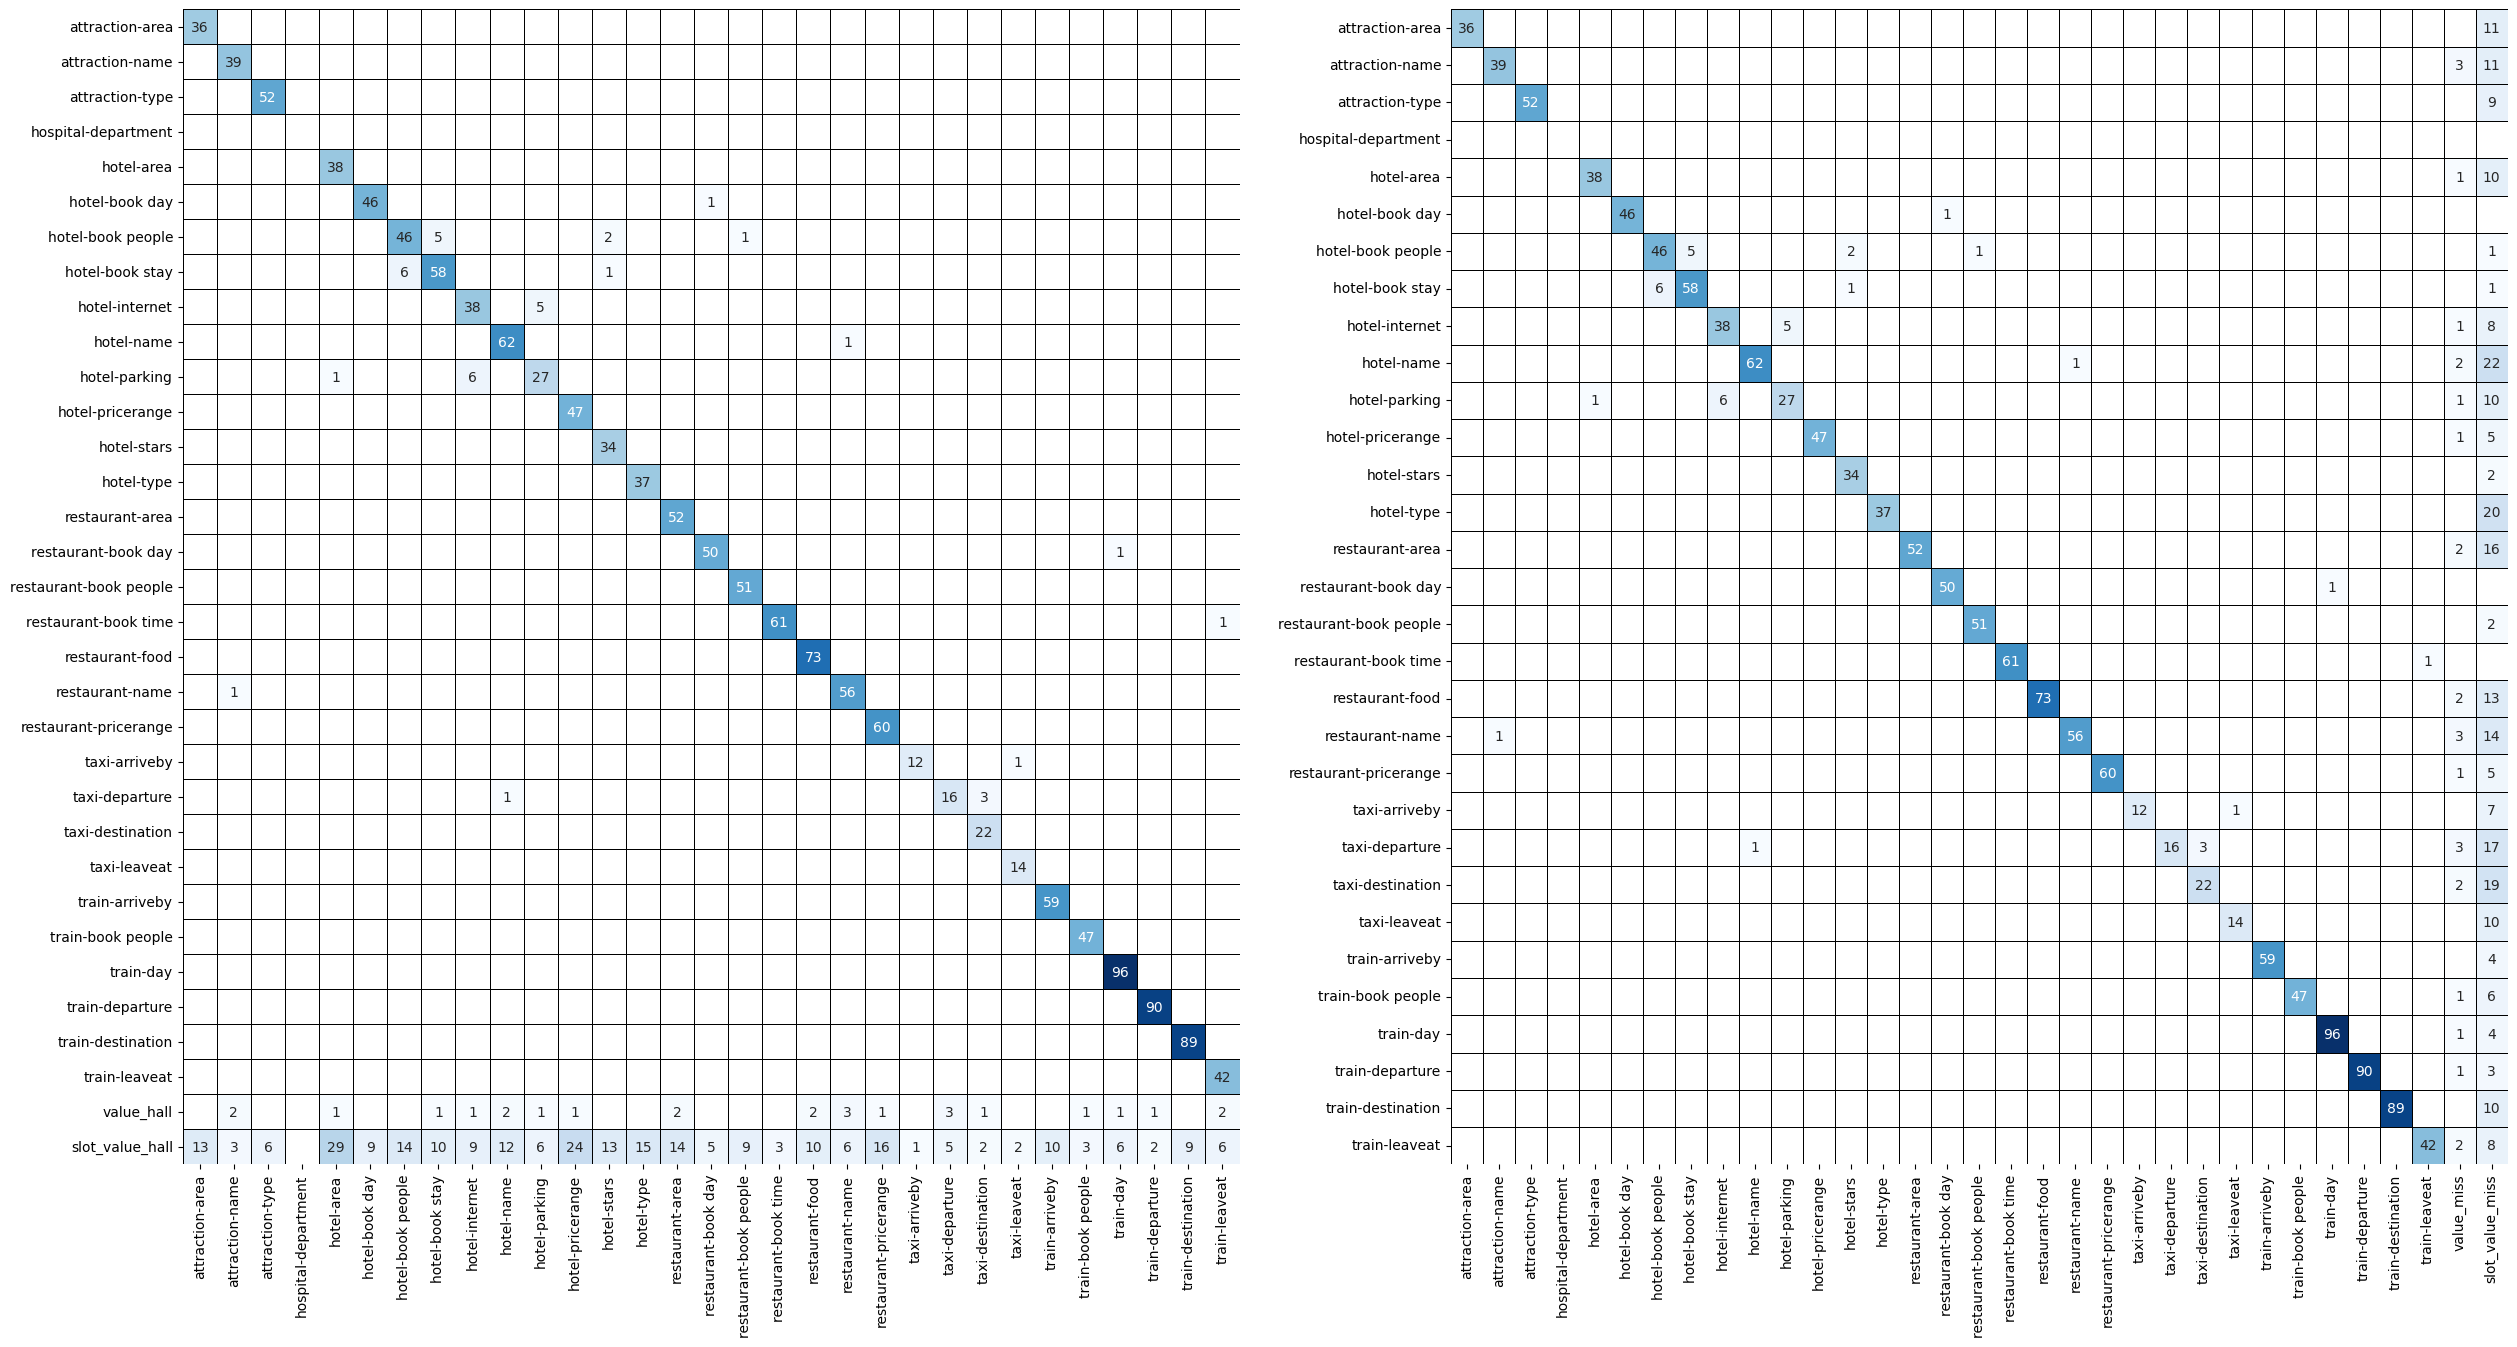

In [9]:
# Convert the confusion matrix to the pandas DataFrame
fig, axes = plt.subplots(1,2, figsize=(30, 15))

pred_delta_df = pd.DataFrame(pred_delta_confusion_matrix).T.drop('text_hallucination', axis=0).dropna()
pred_delta_df = pred_delta_df.applymap(lambda x: len(x))
mask = (pred_delta_df == 0)
sns.heatmap(pred_delta_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', ax=axes[0])

gold_delta_df = pd.DataFrame(gold_delta_confusion_matrix).T.dropna()
gold_delta_df = gold_delta_df.applymap(lambda x: len(x))
mask = (gold_delta_df == 0)
sns.heatmap(gold_delta_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', ax=axes[1])
plt.show()

In [9]:
t1,t2 = [],[]

for s1 in slots:
    # print('---------------------------------')
    for id_turn, pred_delta, slot, value in pred_delta_confusion_matrix['slot_value_hall'][s1]:
        doc_id, turn_id = id_turn.split('_')
        data_item = [item for item in logs if item['ID'] == doc_id+'.json' and item['turn_id'] == int(turn_id)][0]
        sys_utt = data_item['dialog']['sys'][-1]
        usr_utt = data_item['dialog']['usr'][-1]
        d = set(data_item['pred_delta_slot_values'].items()) - set(data_item['pred_prior_context'].items())
        d = dict(d)
        # print(id_turn)
        # print(sys_utt)
        # print(usr_utt)
        # print('gold_delta:', data_item['turn_slot_values'] )
        # print('pred_delta:', pred_delta, slot, value) # data_item['pred_delta_slot_values']
        if value in sys_utt or value in usr_utt:
            # print('!!!!!value in the utterance!!!!!')
            t1.append({'ID':data_item['ID'], 'turn_id':data_item['turn_id'], 'dialog':data_item['dialog'],
             'turn_slot_values':data_item['turn_slot_values'], 'pred_delta':pred_delta, 'slot-value':slot, 'value':value, 'running_pred':d,
             'slot_values': data_item['slot_values'], 'pred':data_item['pred']})
        else:
            t2.append({'ID':data_item['ID'], 'turn_id':data_item['turn_id'], 'dialog':data_item['dialog'],
             'turn_slot_values':data_item['turn_slot_values'], 'pred_delta':pred_delta, 'slot':slot, 'value':value, 'running_pred': d,
             'slot_values': data_item['slot_values'], 'pred':data_item['pred']})
    #     print()
    # print('---------------------------------')
    # print()    
with open('slot_value_hall_value_in_dialog.json','w') as f:
    json.dump(t1, f, indent=4)
with open('slot_value_hall_value_not_in_dialog.json','w') as f:
    json.dump(t2, f, indent=4)

In [13]:
tp_fn = pred_delta_df[:-2].sum(axis=1)
tp_fp = pred_delta_df.sum(axis=0)
tp = pred_delta_df.values.diagonal()
pred_f1 = 2 * tp / (tp_fn + tp_fp)

tp_fn = gold_delta_df.sum(axis=1)
tp_fp = gold_delta_df.iloc[:, :-2].sum(axis=0)
tp = gold_delta_df.values.diagonal()
gold_f1 = 2 * tp / (tp_fn + tp_fp)

delta_stat_df = pd.DataFrame(data={'pred_f1': pred_f1, 'gold_f1': gold_f1, 'slot_f1': slot_f1, 'slot_acc':slot_acc}).dropna().round(4)
print_df = pd.DataFrame()
for col in delta_stat_df.columns:
    tmp = delta_stat_df.sort_values(by=col, ascending=True)[:5]
    tmp.loc['-------'] = ['-------']*len(tmp.columns)
    print_df = pd.concat((print_df, tmp), axis=0)
    # print(stat_df.sort_values(by=col, ascending=True)[:5])

print_df

# 'hotel-area', 'taxi-departure', 'hotel-parking', 'hotel-book people', 'hotel-internet'
# 'taxi-departure', 'taxi-destination', 'hotel-parking', 'taxi-leaveat', 'taxi-arriveby'
# 'hotel-type', 'taxi-departure', 'taxi-destination', 'taxi-leaveat', 'taxi-arriveby'
# 'hotel-type', 'hotel-parking', 'train-leaveat', 'taxi-departure', 'taxi-destination'

,pred_f1,gold_f1,slot_f1,slot_acc
hotel-area,0.2299,0.8,0.8951,0.8893
hotel-stars,0.2386,0.8293,0.9436,0.9869
hotel-parking,0.2478,0.6588,0.8329,0.7137
hotel-internet,0.2508,0.75,0.9434,0.8929
hotel-pricerange,0.2604,0.8868,0.8849,0.8922
-------,-------,-------,-------,-------
hotel-parking,0.2478,0.6588,0.8329,0.7137
taxi-departure,0.3375,0.675,0.8018,0.7583
taxi-arriveby,0.3368,0.7111,0.8244,0.8438
taxi-destination,0.382,0.7234,0.8205,0.8067


In [7]:
"""
All the accumulated Predicted Belief State
"""

pred_confusion_matrix = {gold_slot: {pred_slot:[] for pred_slot in slots} 
                         for gold_slot in slots+['value_hall', 'slot_value_hall']}
pred_confusion_matrix['text_hallucination'] = 0

gold_confusion_matrix = {gold_slot: {pred_slot:[] for pred_slot in slots+['value_miss', 'slot_value_miss']} 
                            for gold_slot in slots}

wrong_by_value = {gold_slot: 0 for gold_slot in slots}

for data_item in logs:

    pred_delta = data_item['pred']
    gold_delta = data_item['slot_values']

    if pred_delta == {} and 'update' not in data_item['completion']: # filter out text hallucination totally wrong generation
        for slot_name in gold_delta:
            pred_confusion_matrix['text_hallucination'] += 1
            continue
    
    for pred_slot, pred_value in pred_delta.items():
        if pred_value in list(gold_delta.values()):
            for gold_slot in [k for k, v in gold_delta.items() if v == pred_value]:
                # pred_confusion_matrix[gold_slot][pred_slot] += 1
                pred_confusion_matrix[gold_slot][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']),pred_delta,  pred_slot, pred_value))
        else:
            if pred_slot in list(gold_delta.keys()):
                # value hall: pred: {gold_slot: wrong_value}
                # pred_confusion_matrix['value_hall'][pred_slot] += 1
                pred_confusion_matrix['value_hall'][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']),pred_delta,  pred_slot, pred_value))
            else:
                # slot_value_hall: pred: {wrong_slot: wrong_value}
                # pred_confusion_matrix['slot_value_hall'][pred_slot] += 1
                pred_confusion_matrix['slot_value_hall'][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), pred_delta, pred_slot, pred_value))

    for gold_slot, gold_value in gold_delta.items():
        if gold_value in list(pred_delta.values()):
            for pred_slot in [k for k, v in pred_delta.items() if v == gold_value]:
                # gold_confusion_matrix[gold_slot][pred_slot] += 1
                gold_confusion_matrix[gold_slot][pred_slot].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))
        else:
            if gold_slot in list(pred_delta.keys()):
                # value miss: pred:{gold_slot: wrong_value}
                # gold_confusion_matrix[gold_slot]['value_miss'] += 1
                gold_confusion_matrix[gold_slot]['value_miss'].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))
            else:
                # slot_value_miss: pred: {wrong_slot: wrong_value}
                # gold_confusion_matrix[gold_slot]['slot_value_miss'] += 1
                gold_confusion_matrix[gold_slot]['slot_value_miss'].append((data_item['ID'].replace('.json', '_')+str(data_item['turn_id']), gold_slot, gold_value))

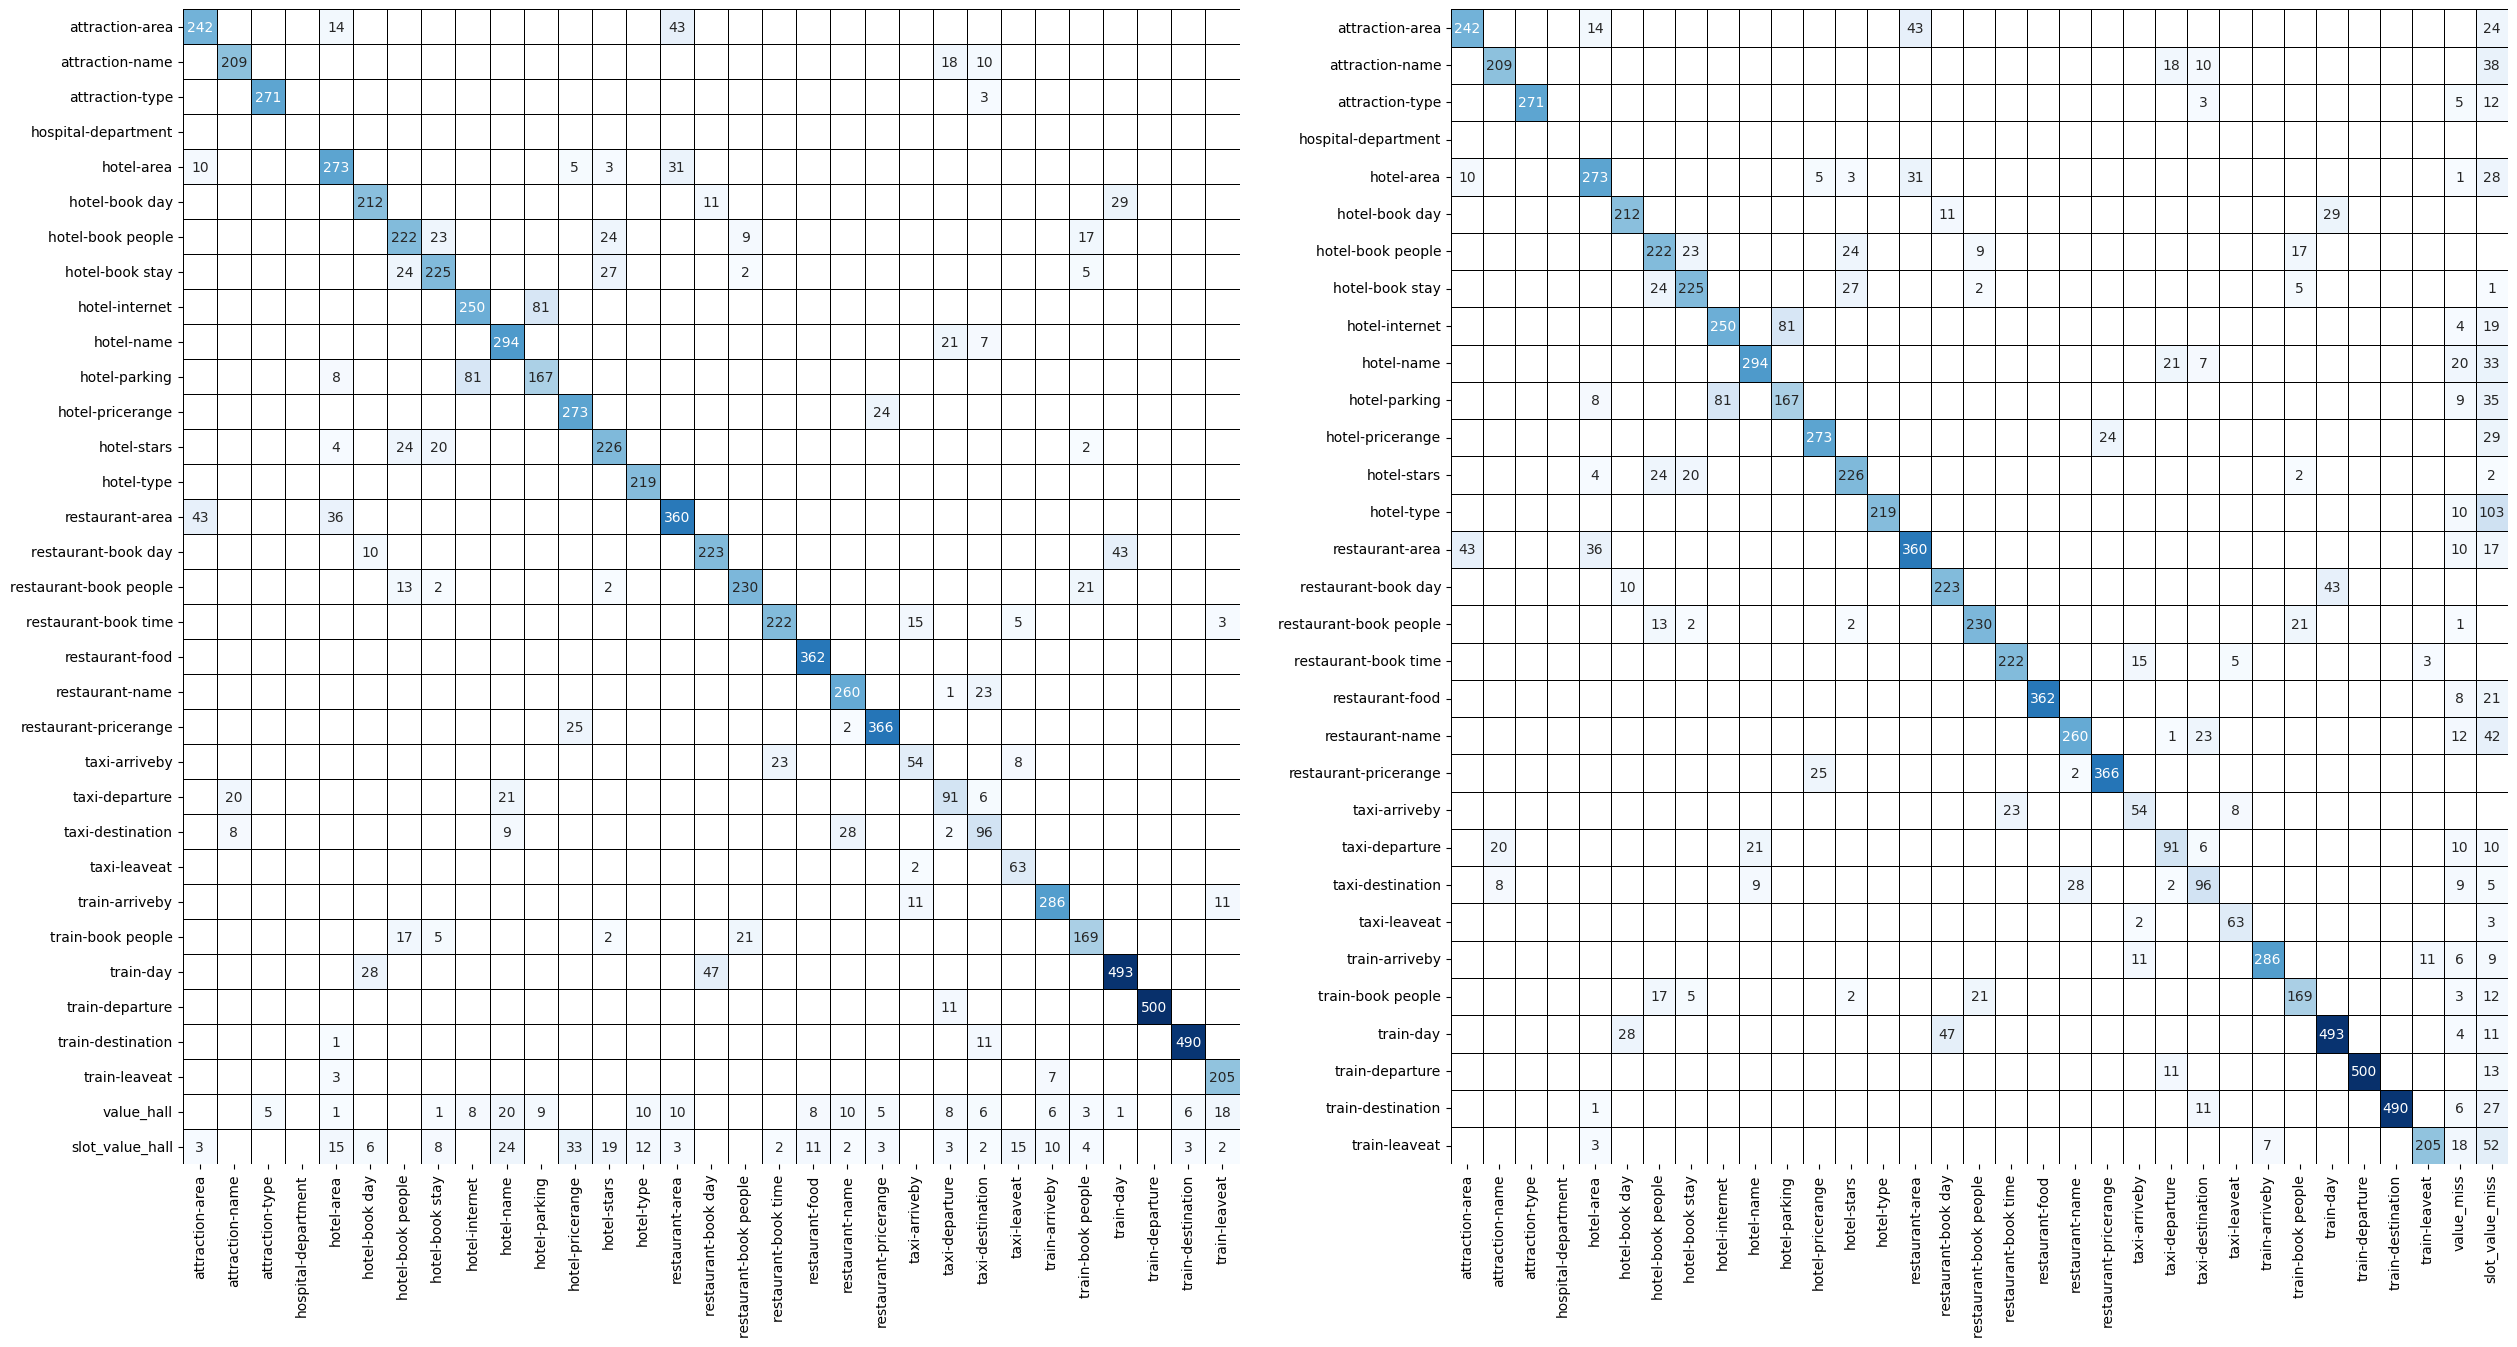

In [8]:
# Convert the confusion matrix to the pandas DataFrame
fig, axes = plt.subplots(1,2, figsize=(30, 15))

pred_df = pd.DataFrame(pred_confusion_matrix).T.drop('text_hallucination', axis=0).dropna()
pred_df = pred_df.applymap(lambda x: len(x))
mask = (pred_df == 0)
sns.heatmap(pred_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', ax=axes[0])

gold_df = pd.DataFrame(gold_confusion_matrix).T.dropna()
gold_df = gold_df.applymap(lambda x: len(x))
mask = (gold_df == 0)
sns.heatmap(gold_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', ax=axes[1])
plt.show()

In [16]:
t1,t2 = [],[]

for s1 in slots:
    # print('---------------------------------')
    for id_turn, pred_delta, slot, value in pred_confusion_matrix['slot_value_hall'][s1]:
        doc_id, turn_id = id_turn.split('_')
        data_item = [item for item in logs if item['ID'] == doc_id+'.json' and item['turn_id'] == int(turn_id)][0]
        sys_utt = data_item['dialog']['sys'][-1]
        usr_utt = data_item['dialog']['usr'][-1]
        d = set(data_item['pred_delta_slot_values'].items()) - set(data_item['pred_prior_context'].items())
        d = dict(d)
        # print(id_turn)
        # print(sys_utt)
        # print(usr_utt)
        # print('gold_delta:', data_item['turn_slot_values'] )
        # print('pred_delta:', pred_delta, slot, value) # data_item['pred_delta_slot_values']
        if value in sys_utt or value in usr_utt:
            # print('!!!!!value in the utterance!!!!!')
            t1.append({'ID':data_item['ID'], 'turn_id':data_item['turn_id'], 'dialog':data_item['dialog'],
             'turn_slot_values':data_item['turn_slot_values'], 'pred_delta':pred_delta, 'slot-value':slot, 'value':value, 'running_pred':d,
             'slot_values': data_item['slot_values'], 'pred':data_item['pred']})
        else:
            t2.append({'ID':data_item['ID'], 'turn_id':data_item['turn_id'], 'dialog':data_item['dialog'],
             'turn_slot_values':data_item['turn_slot_values'], 'pred_delta':pred_delta, 'slot':slot, 'value':value, 'running_pred': d,
             'slot_values': data_item['slot_values'], 'pred':data_item['pred']})
    #     print()
    # print('---------------------------------')
    # print()    
with open('full_state_slot_value_hall_value_in_dialog.json','w') as f:
    json.dump(t1, f, indent=4)
with open('full_state_slot_value_hall_value_not_in_dialog.json','w') as f:
    json.dump(t2, f, indent=4)

In [17]:
tp_fn = pred_delta_df[:-2].sum(axis=1)
tp_fp = pred_delta_df.sum(axis=0)
tp = pred_delta_df.values.diagonal()
pred_f1 = 2 * tp / (tp_fn + tp_fp)

tp_fn = gold_delta_df.sum(axis=1)
tp_fp = gold_delta_df.iloc[:, :-2].sum(axis=0)
tp = gold_delta_df.values.diagonal()
gold_f1 = 2 * tp / (tp_fn + tp_fp)

delta_stat_df = pd.DataFrame(data={'pred_f1': pred_f1, 'gold_f1': gold_f1, 'slot_f1': slot_f1, 'slot_acc':slot_acc}).dropna().round(4)
print_df = pd.DataFrame()
for col in delta_stat_df.columns:
    tmp = delta_stat_df.sort_values(by=col, ascending=True)[:5]
    tmp.loc['-------'] = ['-------']*len(tmp.columns)
    print_df = pd.concat((print_df, tmp), axis=0)
    # print(stat_df.sort_values(by=col, ascending=True)[:5])

print_df
# 'hotel-area', 'hotel-stars', 'hotel-parking', 'hotel-internet', 'hotel-pricerange'
# 'hotel-parking', 'taxi-departure', 'taxi-arriveby', 'taxi-destination', 'hotel-internet'
# 'hotel-type', 'taxi-departure', 'taxi-destination', 'taxi-leaveat', 'taxi-arriveby'
# 'hotel-type', 'hotel-parking', 'train-leaveat', 'taxi-departure', 'taxi-destination'

,pred_f1,gold_f1,slot_f1,slot_acc
hotel-area,0.2299,0.8,0.8951,0.8893
hotel-stars,0.2386,0.8293,0.9436,0.9869
hotel-parking,0.2478,0.6588,0.8329,0.7137
hotel-internet,0.2508,0.75,0.9434,0.8929
hotel-pricerange,0.2604,0.8868,0.8849,0.8922
-------,-------,-------,-------,-------
hotel-parking,0.2478,0.6588,0.8329,0.7137
taxi-departure,0.3375,0.675,0.8018,0.7583
taxi-arriveby,0.3368,0.7111,0.8244,0.8438
taxi-destination,0.382,0.7234,0.8205,0.8067


In [18]:
pred_delta_confusion_matrix = {gold_slot: {pred_slot:0 for pred_slot in slots} 
                         for gold_slot in slots+['value_hall', 'slot_value_hall']}
pred_delta_confusion_matrix['text_hallucination'] = 0

gold_delta_confusion_matrix = {gold_slot: {pred_slot:0 for pred_slot in slots+['value_miss', 'slot_value_miss']} 
                            for gold_slot in slots}

wrong_by_value = {gold_slot: 0 for gold_slot in slots}

gold_cnt = 0
pred_cnt = 0
for data_item in logs:
    # pred_delta = parse_python_completion(data_item['completion'], {})
    # pred_delta_ =  normalizer.normalize(pred_delta)
    # pred_delta.update(pred_delta_)
    pred_delta = data_item['pred_delta_slot_values']
    pred_slots, pred_values = set(pred_delta.keys()), set(pred_delta.values())
    pred_value_slot = {v:k for k, v in pred_delta.items()}

    gold_delta = data_item['turn_slot_values']
    gold_slots, gold_values = set(gold_delta.keys()), set(gold_delta.values())
    gold_value_slot = {v: k for k, v in gold_delta.items()}

    if pred_delta == {} and 'update' not in data_item['completion']: # filter out text hallucination totally wrong generation
        for slot_name in gold_delta:
            pred_delta_confusion_matrix['text_hallucination'] += 1
            continue
    
    for pslot, pvalue in pred_delta.items():
        if pvalue in gold_values:
            gslot_list = [k for k, v in gold_delta.items() if v == pvalue]
            for gslot in gslot_list:
                if gslot == pslot:
                    # correct
                    pred_delta_confusion_matrix[gslot][pslot] += 1
                else:
                    # correct value but wrong slot
                    pred_delta_confusion_matrix[gslot][pslot] += 1                    
        else:
            # predict value not in gold values
            pred_delta_confusion_matrix['value_hall'][pslot] += 1
    
    # pred {h-a: center, r-a: center}
    # gold {h-a: center}
    for gslot, gvalue in gold_delta.items():
        if (gslot, gvalue) in pred_delta.items():
            """"
            gold={h-a: center},      pred={h-a: center, r-a: center}
            이렇게 되면 한 (gslot, gvalue) 에 대해서 한 번만 count 됨.
            맞는 경우인, gold (h-a:center ) <-> pred (h-a:center) 는 1번만 count 됨
            confuse한 경우인, gold (h-a:center) <-> pred (r-a:center) 는 count 안됨.
            pred_confusion_matrix의 off-diagonal 과 달라지게 됨.
            """
            # correct
            gold_delta_confusion_matrix[gslot][gslot] += 1
            continue

        
        pslot_list = [k for k, v in pred_delta.items() if v == gvalue]            
        for pslot in pslot_list:
            # confuse the gslot as pslot
            gold_delta_confusion_matrix[gslot][pslot] += 1
        if len(pslot_list) == 0:
            # gold values not in predict value
            gold_delta_confusion_matrix[gslot]['value_miss'] += 1


In [ ]:
# Convert the confusion matrix to the pandas DataFrame
pred_df = pd.DataFrame(pred_delta_confusion_matrix).T
pred_df = pred_df.drop('text_hallucination', axis=0)
mask = (pred_df == 0)

plt.figure(figsize=(10,10))
sns.heatmap(pred_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.show()

# Convert the confusion matrix to the pandas DataFrame
gold_df = pd.DataFrame(gold_delta_confusion_matrix).T
mask = (gold_df == 0)

plt.figure(figsize=(10,10))
sns.heatmap(gold_df, mask=mask, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
plt.show()

In [ ]:
tp_fn = pred_df[:-2].sum(axis=1)
tp_fp = pred_df.sum(axis=0)
tp = pred_df.values.diagonal()
tp_fn.shape, tp_fp.shape, tp.shape

# f1 score
pred_f1 = 2 * tp / (tp_fn + tp_fp)

tp_fn = gold_df.sum(axis=1)
tp_fp = gold_df.iloc[:, :-2].sum(axis=0)
tp = gold_df.values.diagonal()
tp_fn.shape, tp_fp.shape, tp.shape
# f1 score
gold_f1 = 2 * tp / (tp_fn + tp_fp)

stat_df = pd.DataFrame(data={'pred_f1': pred_f1, 'gold_f1': gold_f1, 'slot_f1': slot_f1}).dropna()
stat_df.sort_values(by='pred_f1', ascending=True)[:7], stat_df.sort_values(by='gold_f1', ascending=True)[:7], stat_df.sort_values(by='slot_f1', ascending=True)[:7]


# ---------------------------   EOC ---------------------------

In [21]:
from collections import defaultdict
gold = {'s1': 'v1', 's2': 'v2'}

# slots: s1, s2, s3, s4
# values: v1, v2, v3, v4
preds=[
# pred 값이 0개
# {},
# pred 값이 1개
{'s1': 'v1'},
{'s1': 'v2'},
{'s1': 'v3'},
{'s2': 'v1'},
{'s2': 'v2'},
{'s2': 'v3'},
{'s3': 'v1'},
{'s3': 'v2'},
{'s3': 'v3'},

#slot 값이 모두 맞은 경우
{'s1': 'v1', 's2': 'v1'},
{'s1': 'v1', 's2': 'v2'},
{'s1': 'v1', 's2': 'v3'},

{'s1': 'v2', 's2': 'v1'},
{'s1': 'v2', 's2': 'v2'},
{'s1': 'v2', 's2': 'v3'},

{'s1': 'v3', 's2': 'v1'},
{'s1': 'v3', 's2': 'v2'},
{'s1': 'v3', 's2': 'v3'},
{'s1': 'v3', 's2': 'v4'},

# slot 값이 하나만 틀린 경우 
# gold slot에 없는 값으로 틀린 경우
{'s1': 'v1', 's3': 'v1'},
{'s1': 'v1', 's3': 'v2'},
{'s1': 'v1', 's3': 'v3'},

{'s1': 'v2', 's3': 'v1'},
{'s1': 'v2', 's3': 'v2'},
{'s1': 'v2', 's3': 'v3'},

{'s1': 'v3', 's3': 'v1'},
{'s1': 'v3', 's3': 'v2'},
{'s1': 'v3', 's3': 'v3'},
{'s1': 'v3', 's3': 'v4'},
###############
{'s3': 'v1', 's2': 'v1'},
{'s3': 'v1', 's2': 'v2'},
{'s3': 'v1', 's2': 'v3'},

{'s3': 'v2', 's2': 'v1'},
{'s3': 'v2', 's2': 'v2'},
{'s3': 'v2', 's2': 'v3'},

{'s3': 'v3', 's2': 'v1'},
{'s3': 'v3', 's2': 'v2'},
{'s3': 'v3', 's2': 'v3'},
{'s3': 'v3', 's2': 'v4'},

# slot 값이 모두 틀린 경우 
# 두 slot 값이 다른 경우
{'s3': 'v1', 's4': 'v1'},
{'s3': 'v1', 's4': 'v2'},
{'s3': 'v1', 's4': 'v3'},

{'s3': 'v2', 's4': 'v1'},
{'s3': 'v2', 's4': 'v2'},
{'s3': 'v2', 's4': 'v3'},

{'s3': 'v3', 's4': 'v1'},
{'s3': 'v3', 's4': 'v2'},
{'s3': 'v3', 's4': 'v3'},
{'s3': 'v3', 's4': 'v4'}
]

slots = ['s1', 's2', 's3', 's4']
values = ['v1', 'v2', 'v3', 'v4']


In [22]:
""" Slot 기준으로 할 때 """

pred_conf_mat = {g_slot : {p_slot:[] for p_slot in slots} for g_slot in slots+['value_hall', 'slot_value_hall']}
gold_conf_mat = {g_slot : {p_slot:[] for p_slot in slots+['value_miss', 'slot_value_miss']} for g_slot in slots}

for idx, pred in enumerate(preds):
    for pred_slot, pred_value in pred.items():
        if pred_slot in list(gold.keys()):
            gold_value = gold[pred_slot]
            if gold_value == pred_value:
                # correct
                pred_conf_mat[pred_slot][pred_slot].append((idx, pred_slot, pred_value))
            else:
                # value hall: predict gold_value as pred_value
                pred_conf_mat['value_hall'][pred_slot].append((idx, pred_slot, pred_value))
        else:
            if pred_value in [v for k, v in gold.items()]:
                gold_slot_pval = [k for k, v in gold.items() if v == pred_value]
                for gold_slot in gold_slot_pval:
                    # slot hall: confuse gold_slot as pred_slot
                    pred_conf_mat[gold_slot][pred_slot].append((idx, pred_slot, pred_value))
            else:
                pred_conf_mat['slot_value_hall'][pred_slot].append((idx, pred_slot, pred_value))
    
    for gold_slot, gold_value in gold.items():
        if gold_slot in list(pred.keys()):
            pred_value = pred[gold_slot]
            if gold_value == pred_value:
                # correct
                gold_conf_mat[gold_slot][gold_slot].append((idx, gold_slot, pred_value))
            else:
                # pred slot이 gold slot 에 있고, 그 같은 slot에 대해서 value가 틀린것
                # value miss: predict gold_value as pred_value
                gold_conf_mat[gold_slot]['value_miss'].append((idx, gold_slot, pred_value))
        else:
            if gold_value in [v for k, v in pred.items()]:
                pred_slot_pval = [k for k, v in pred.items() if v == gold_value]
                for pred_slot in pred_slot_pval:
                    # slot miss: confuse gold_slot as pred_slot
                    gold_conf_mat[gold_slot][pred_slot].append((idx, pred_slot, pred_value))
            else:
                gold_conf_mat[gold_slot]['slot_value_miss'].append((idx, pred_slot, pred_value))

In [23]:
""" Value 기준으로 할 때 """

pred_conf_mat = {g_slot : {p_slot:[] for p_slot in slots} for g_slot in slots+['value_hall', 'slot_value_hall']}
gold_conf_mat = {g_slot : {p_slot:[] for p_slot in slots+['value_miss', 'slot_value_miss']} for g_slot in slots}

for idx, pred in enumerate(preds):
    for pred_slot, pred_value in pred.items():
        if pred_value in list(gold.values()):
            for gold_slot in [k for k, v in gold.items() if v == pred_value]:
                pred_conf_mat[gold_slot][pred_slot].append((idx, pred_slot, pred_value))
        else:
            if pred_slot in list(gold.keys()):
                # value hall: predict gold_value as pred_value
                pred_conf_mat['value_hall'][pred_slot].append((idx, pred_slot, pred_value))
            else:
                # slot value hall: predict gold_slot as pred_slot and gold_value as pred_value
                pred_conf_mat['slot_value_hall'][pred_slot].append((idx, pred_slot, pred_value))

    for gold_slot, gold_value in gold.items():
        if gold_value in list(pred.values()):
            for pred_slot in [k for k, v in pred.items() if v == gold_value]:
                gold_conf_mat[gold_slot][pred_slot].append((idx, pred_slot, pred[pred_slot]))
        else:
            if gold_slot in list(pred.keys()):
                # value miss: gold_slot is in pred but pred:{gold_slot: wrong_value}
                gold_conf_mat[gold_slot]['value_miss'].append((idx, pred_slot, pred_value))
            else:
                # pred miss all the gold values
                gold_conf_mat[gold_slot]['slot_value_miss'].append((idx, pred_slot, pred_value))
    
    # for gold_slot, gold_value in gold.items():
    #     if (gold_slot, gold_value) in pred.items():
    #         # correct
    #         gold_conf_mat[gold_slot][gold_slot].append((idx, gold_slot, gold_value))
    # #         continue
        
    #     pred_slot_list = [k for k, v in pred.items() if v == gold_value]            
    #     for pred_slot in pred_slot_list:
    #         pred_value = pred[pred_slot]
    #         # confuse the gold slot as pred slot
    #         gold_conf_mat[gold_slot][pred_slot].append((idx, pred_slot, pred_value))
    #     if len(pred_slot_list) == 0:
    #         # gold values not in predict value
    #         gold_conf_mat[gold_slot]['missing'].append((idx))